# Dragon Lake Parking (DLP) Dataset

This notebook walks through usage of the Parking Dataset API.

### Setup

The `load()` method loads all JSON files for a scene. In this example, we are loading:

- `data/DJI_0001_frames.json`
- `data/DJI_0001_agents.json`
- `data/DJI_0001_instances.json`
- `data/DJI_0001_obstacles.json`
- `data/DJI_0001_scene.json`

In [1]:
from dlp.dataset import Dataset

ds = Dataset()
ds.load('./data/DJI_0012')

### Scenes

We can use `list_scenes()` to obtain a list of tokens corresponding to scenes that have been loaded.

In [2]:
all_scenes = ds.list_scenes()
all_scenes

['66045def24565e370dff814aa01e8ffed07318b9']

Use `get()` to look up a data object by its token.

In [3]:
scene_token = all_scenes[0]
scene = ds.get('scene', scene_token)
print("Keys:", scene.keys())
print("Scene_token:", scene['scene_token'])
print("filename:", scene['filename'])
print("timestamp:", scene['timestamp'])
print("first_frame:", scene['first_frame'])
print("last_frame:", scene['last_frame'])
print("agents (preview):", scene['agents'][:2])
print("obstacles (preview):", scene['obstacles'][:2])

Keys: dict_keys(['scene_token', 'filename', 'timestamp', 'first_frame', 'last_frame', 'agents', 'obstacles'])
Scene_token: 66045def24565e370dff814aa01e8ffed07318b9
filename: DJI_0012
timestamp: 2020-08-08 10:08:03
first_frame: 840d7356e46973280c5e71d628fc3b240bfd040a
last_frame: 989b3f56582cdc1af8b1a5a51693bd83327851c9
agents (preview): ['a1b3619e3bc68c3de29af54ba9ff3de96c7de3dc', '44bcb749f3901204f4aba6e35615f5e026d7c4cc']
obstacles (preview): ['02778fb4cafec30d01ba4e59a8eb53f19c3b9c86', '8d08ec553539276f33cba6aa12eed8fc07371672']


### Loading the processed data

In [156]:
import pickle
# Loading the data
with open("Data_time_all", "rb") as fp:
    Data_time_all_load = pickle.load(fp)
    
with open("Data_agent_all", "rb") as fp:
    Data_agent_all_load = pickle.load(fp)

### Processing data for SGAN training

In [157]:
import numpy as np
time_steps_skip = 10 # dt in processed_data will be time_steps_skip*0.04, since 0.04 is the original dt
end_time_focus = 200 # start_time+end_time_focus = end_time in each scneario
times_scenarios = np.arange(500, 6000, 200).tolist() # start_time for each scenario (time_focus)
n_agents = 5

train_data = []

for start_time in times_scenarios:
    time_focus = np.arange(start_time ,start_time + end_time_focus, time_steps_skip).tolist()
    Data_time_focus = [Data_time_all_load[t] for t in time_focus]
    Data_time_agents_focus = [dict(list(agents.items())[:n_agents]) for agents in Data_time_focus]
    agent_tokens = list(Data_time_agents_focus[0].keys())
#     state_time_agent = [[data_time[agent_token]['coords'] + 
#     [data_time[agent_token]['heading']] for agent_token in agent_tokens] for data_time in Data_time_agents_focus] 
#     train_data.append(np.transpose(np.array(state_time_agent), (2, 0, 1))) # result is 3 (states) x T (time) x N (no. of agents)
    agents_each_time = [list(agents) for agents in Data_time_agents_focus]
    # print("Size of current scenario data: ", train_data[-1].shape)
    print("Same agents: ", all(i == agents_each_time[0] for i in agents_each_time))

Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True
Same agents:  True


In [127]:
with open("val_data", "wb") as fp:
    pickle.dump(train_data, fp)

In [158]:
agent_tokens_all = scene['agents']

In [165]:
Data_agent_all_load[2]

{0: {'instance_token': '5d85afdb3e31d4ece65f0de6b6b9d6863dfb08d5',
  'agent_token': '961c7ae677f816c35c7b1fc4eed6ff57735cd8a2',
  'frame_token': '840d7356e46973280c5e71d628fc3b240bfd040a',
  'coords': [15.540000000037253, 75.50999999977648],
  'heading': 1.9374073464102066,
  'speed': 0.0,
  'acceleration': [0.0, 0.0004],
  'mode': '',
  'prev': '',
  'next': '03a9b5a360fc3b846588c856153f210b3bcf6455'},
 1: {'instance_token': '03a9b5a360fc3b846588c856153f210b3bcf6455',
  'agent_token': '961c7ae677f816c35c7b1fc4eed6ff57735cd8a2',
  'frame_token': 'd33ba31ba918b2f4f4345e31f262bb1cab2a6be6',
  'coords': [15.540000000037253, 75.50999999977648],
  'heading': 1.9374073464102066,
  'speed': 0.0,
  'acceleration': [0.0, 0.0005],
  'mode': '',
  'prev': '5d85afdb3e31d4ece65f0de6b6b9d6863dfb08d5',
  'next': '0ce202f147c685ff4cd0f0edb4be6ae60ec5dfeb'},
 2: {'instance_token': '0ce202f147c685ff4cd0f0edb4be6ae60ec5dfeb',
  'agent_token': '961c7ae677f816c35c7b1fc4eed6ff57735cd8a2',
  'frame_token': '

### Processing and saving the data for our usage

In [113]:
agent_tokens_all = scene['agents']
frame_tokens_all = list(ds.frames)
Data_time_all = [] # Time step (integer) -> agent token -> instance object
## Iterating through time steps
for frame_token in frame_tokens_all:
    agents_all = {} # Agent map: key = agent token, value = instance object
    # For each time step t, Iterating through all the agents, i.e., instances
    for instance_token in ds.frames[frame_token]['instances']:
        instance = ds.get('instance', instance_token)
        agents_all[instance['agent_token']] = instance # store the instance object in the agent map
    Data_time_all.append(agents_all)

In [150]:
Data_agent_all = [] # agent (integer, ordered wrt agent_tokens_all) -> time step -> instance object
dt = 0.04
## Iterating through agents
for agent_token in agent_tokens_all:
    time_all = {} # Time map: key = time step, value = instance object
    # For each agent i, Iterating through all its instances, i.e. time
    for frame_token in frame_tokens_all:
        frame = ds.get('frame', frame_token)
        instances_in_frame = frame['instances']
        for instance_token in  instances_in_frame:
            instance = ds.get('instance', instance_token)
            if agent_token == instance['agent_token']:                
                time_all[int(frame['timestamp']/dt)] = instance # store the instance object in the Time map
    Data_agent_all.append(time_all)

In [196]:
## Saving the data
import pickle
with open("Data_time_all", "wb") as fp:
    pickle.dump(Data_time_all, fp)

with open("Data_agent_all", "wb") as fp:
    pickle.dump(Data_agent_all, fp)

### Playing and verifiying with the processed data

In [173]:
coords_all = []
for instance in Data_agent_all[101].values():
    coords_all.append(instance['coords'])
coords_n = np.array(coords_all)

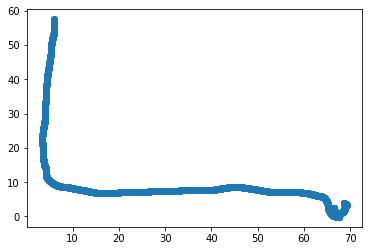

In [178]:
import matplotlib.pyplot as plt
plt.plot(coords_n[:, 0], coords_n[:, 1], marker='o')

In [192]:
list(Data_agent_all[101].values())[394]

{'instance_token': '89e1856558579f033c7b291540cce53332bf881b',
 'agent_token': 'e0dc900ed81af71a4d04e29b3db86a37b2927b31',
 'frame_token': '7dd7c16ecf6d98cb973cc8d9d07b4a3e33cf0066',
 'coords': [67.14000000001397, 0.7400000002235174],
 'heading': 2.9676073464102073,
 'speed': 0.64,
 'acceleration': [-2.1736, -0.4318],
 'mode': '',
 'prev': '6a6ad345fbeac30b5495e7e3f75d2736f66ad672',
 'next': '18b9ad5e37c23757ac3e29ddb3ae9a06ece56182'}

In [191]:
coords_n[394]

array([67.14,  0.74])

In [193]:
list(Data_agent_all[101])

[5070,
 5071,
 5072,
 5073,
 5074,
 5075,
 5076,
 5077,
 5078,
 5079,
 5080,
 5081,
 5082,
 5083,
 5084,
 5085,
 5086,
 5087,
 5088,
 5089,
 5090,
 5091,
 5092,
 5093,
 5094,
 5095,
 5096,
 5097,
 5098,
 5099,
 5100,
 5101,
 5102,
 5103,
 5104,
 5105,
 5106,
 5107,
 5108,
 5109,
 5110,
 5111,
 5112,
 5113,
 5114,
 5115,
 5116,
 5117,
 5118,
 5119,
 5120,
 5121,
 5122,
 5123,
 5124,
 5125,
 5126,
 5127,
 5128,
 5129,
 5130,
 5131,
 5132,
 5133,
 5134,
 5135,
 5136,
 5137,
 5138,
 5139,
 5140,
 5141,
 5142,
 5143,
 5144,
 5145,
 5146,
 5147,
 5148,
 5149,
 5150,
 5151,
 5152,
 5153,
 5154,
 5155,
 5156,
 5157,
 5158,
 5159,
 5160,
 5161,
 5162,
 5163,
 5164,
 5165,
 5166,
 5167,
 5168,
 5169,
 5170,
 5171,
 5172,
 5173,
 5174,
 5175,
 5176,
 5177,
 5178,
 5179,
 5180,
 5181,
 5182,
 5183,
 5184,
 5185,
 5186,
 5187,
 5188,
 5189,
 5190,
 5191,
 5192,
 5193,
 5194,
 5195,
 5196,
 5197,
 5198,
 5199,
 5200,
 5201,
 5202,
 5203,
 5204,
 5205,
 5206,
 5207,
 5208,
 5209,
 5210,
 5211,
 5212,

In [167]:
import numpy as np
np.where(np.diff(list(Data_agent_all[101])) != 1)

(array([ 395,  419,  443,  467,  491,  515,  539,  563,  587,  611,  635,
         659,  683,  707,  731,  755,  779,  803,  827,  851,  875,  899,
         923,  947,  971,  995, 1019, 1043, 1067, 1091, 1115, 1139, 1163,
        1187, 1211, 1235, 1259, 1283, 1293, 1297, 1299, 1301, 1303, 1307,
        1309, 1311, 1315, 1317, 1319, 1321, 1325, 1327, 1329, 1333, 1335,
        1337, 1339, 1343, 1345, 1347, 1351, 1353, 1355, 1357, 1361, 1363,
        1365, 1369, 1371, 1373, 1375, 1379, 1381, 1383, 1387, 1389, 1391,
        1393, 1397, 1399, 1401, 1405, 1407, 1409, 1411, 1415, 1417, 1419,
        1423, 1425, 1427, 1429, 1433, 1435, 1437, 1441, 1443, 1445, 1447,
        1451, 1453, 1455, 1459, 1461, 1463, 1465, 1469, 1471, 1473, 1477,
        1479, 1481, 1483, 1487, 1489, 1491, 1495, 1497, 1499, 1501, 1505,
        1507, 1509, 1513, 1515, 1517, 1519, 1523, 1525, 1527, 1531, 1533,
        1535, 1537, 1541, 1543, 1545, 1549, 1551, 1553, 1555, 1559, 1561,
        1563, 1567, 1569, 1571, 1573, 

### Frames

Let's look at the first frame in the scene:

In [4]:
frame_token = scene['first_frame']
frame = ds.get('frame', frame_token)
print("Keys:", frame.keys())
print("frame_token:", frame['frame_token'])
print("scene_token:", frame['scene_token'])
print("timestamp:", frame['timestamp'])
print("instances (preview):", frame['instances'][:2])

Keys: dict_keys(['frame_token', 'scene_token', 'timestamp', 'prev', 'next', 'instances'])
frame_token: 840d7356e46973280c5e71d628fc3b240bfd040a
scene_token: 66045def24565e370dff814aa01e8ffed07318b9
timestamp: 0.0
instances (preview): ['0a72735ac3b5f6f50bfa50ad8e91ac3e40277854', 'f7db24901446b67361768323726b312db36b0f36']


We can use the `get_frame_at_time()` method to get the frame at a certian time. The specified time to query can be any float value (in secs) within the total length of the video, and the method will return the closet frame towards that time. The example below returns the frame at about 15.00s of the video. 

In [5]:
frame = ds.get_frame_at_time(scene_token, 15)
print("Keys:", frame.keys())
print("frame_token:", frame['frame_token'])
print("scene_token:", frame['scene_token'])
print("timestamp:", frame['timestamp'])
print("instances (preview):", frame['instances'][:2])

Keys: dict_keys(['frame_token', 'scene_token', 'timestamp', 'prev', 'next', 'instances'])
frame_token: eb2ef77677af5b7ff0407fbe3da726e34c753e0e
scene_token: 66045def24565e370dff814aa01e8ffed07318b9
timestamp: 15.0
instances (preview): ['84a6e130a4416de716ea54c632362f633dcdf58d', '56896ce286c1836f8579c977f65d938119e561b1']


We can use the `get_future_frames()` or `get_past_frames()` methods look at a specified number of preceding/subsequent frames. The example below returns a list containing the given frame and the next 5 frames.

In [6]:
future_frames = ds.get_future_frames(frame_token, timesteps=5)
print("Keys:", future_frames[0].keys())

Keys: dict_keys(['frame_token', 'scene_token', 'timestamp', 'prev', 'next', 'instances'])


### Agents

Now let's look at an agent:

In [7]:
agent_token = scene['agents'][0]
agent = ds.get('agent', agent_token)
agent

{'agent_token': 'a1b3619e3bc68c3de29af54ba9ff3de96c7de3dc',
 'scene_token': '66045def24565e370dff814aa01e8ffed07318b9',
 'type': 'Car',
 'size': [4.7048, 1.8778],
 'first_instance': '0a72735ac3b5f6f50bfa50ad8e91ac3e40277854',
 'last_instance': 'f1479898cad572acaabc6f4c3aa90d21030cb89a'}

Use `get_agent_instances()` to see all instances of an agent in the scene.

In [8]:
agent_instances = ds.get_agent_instances(agent_token)

print("Keys:", agent_instances[0].keys())
print("coords:", agent_instances[0]['coords'])
print("heading:", agent_instances[0]['heading'])
print("speed:", agent_instances[0]['speed'])
print("acceleration:", agent_instances[0]['acceleration'])
print("mode:", agent_instances[0]['mode'])
print("prev:", agent_instances[0]['prev'])
print("next:", agent_instances[0]['next'])

Keys: dict_keys(['instance_token', 'agent_token', 'frame_token', 'coords', 'heading', 'speed', 'acceleration', 'mode', 'prev', 'next'])
coords: [88.55000000004657, 63.47999999998137]
heading: 1.328607346410207
speed: 0.23
acceleration: [0.0056, 0.0089]
mode: 
prev: 
next: 2e40de975f5ec83c4831c54f8cb58275785a3ea8


### Instances

This is the last instance of our agent in the scene:

In [9]:
instance_token = agent['last_instance']
instance = ds.get('instance', instance_token)
instance

{'instance_token': 'f1479898cad572acaabc6f4c3aa90d21030cb89a',
 'agent_token': 'a1b3619e3bc68c3de29af54ba9ff3de96c7de3dc',
 'frame_token': '989b3f56582cdc1af8b1a5a51693bd83327851c9',
 'coords': [87.81000000005588, 58.43000000016764],
 'heading': 1.535607346410207,
 'speed': 0.0,
 'acceleration': [0.0, 0.0],
 'mode': '',
 'prev': '17df17632f8e8533b7b17052ee97a2e3cd2b3385',
 'next': ''}

We can search for the closest instance at a certain location with `get_inst_at_location()` method:

In [10]:
closest_instance = ds.get_inst_at_location(frame_token, [90, 65])
closest_instance

{'instance_token': '0a72735ac3b5f6f50bfa50ad8e91ac3e40277854',
 'agent_token': 'a1b3619e3bc68c3de29af54ba9ff3de96c7de3dc',
 'frame_token': '840d7356e46973280c5e71d628fc3b240bfd040a',
 'coords': [88.55000000004657, 63.47999999998137],
 'heading': 1.328607346410207,
 'speed': 0.23,
 'acceleration': [0.0056, 0.0089],
 'mode': '',
 'prev': '',
 'next': '2e40de975f5ec83c4831c54f8cb58275785a3ea8'}

We can use the `get_agent_future()` or `get_agent_past()` methods to look at a specified number of future/past instances of this agent. The example below returns a list containing the previous 5 instances along with the given instance.

In [11]:
past_instances = ds.get_agent_past(instance_token, timesteps=5)

print("Keys:", past_instances[0].keys())
print("coords:", past_instances[0]['coords'])
print("heading:", past_instances[0]['heading'])
print("speed:", past_instances[0]['speed'])
print("acceleration:", past_instances[0]['acceleration'])
print("mode:", past_instances[0]['mode'])
print("prev:", past_instances[0]['prev'])
print("next:", past_instances[0]['next'])

Keys: dict_keys(['instance_token', 'agent_token', 'frame_token', 'coords', 'heading', 'speed', 'acceleration', 'mode', 'prev', 'next'])
coords: [87.81000000005588, 58.43000000016764]
heading: 1.535607346410207
speed: 0.0
acceleration: [0.0, 0.0]
mode: 
prev: 42ec0e2ae2f53abff3e32421c8f5447ea5e70bc1
next: 062e10ea3c98e641ca0f8e49892e13ebcd363e29


By default, the speed value in the instance is the absolute value. To obtain the "signed" speed so that it is negative when vehicle is backing up, use `signed_speed()` function

In [12]:
signed_speed = ds.signed_speed(inst_token=instance_token)
print('signed_speed:', signed_speed)

signed_speed: -0.0


Besides a list of future instances, it is also possible to get an Tx4 numpy array as the vehicle's future trajectory

In [13]:
future_traj = ds.get_future_traj(inst_token=instance_token)
print(future_traj)

[[87.81       58.43        1.53560735 -0.        ]]


An instance will have one of the stree modes:
* 'parked': if the current instance is just static inside a parking spot
* 'outgoing`: if the currrent instance is on the way towards the exit
* 'incoming`: if the current instance is searching for a parking spot
* 'unclear`: we cannot tell the vehicle's intent given the data recording

The `get_inst_mode()` function will not only return the mode of the specified instance, but also write the mode into the instance object for later use

In [14]:
mode = ds.get_inst_mode(inst_token=instance_token)
print('returned mode:', mode)
instance

returned mode: parked


{'instance_token': 'f1479898cad572acaabc6f4c3aa90d21030cb89a',
 'agent_token': 'a1b3619e3bc68c3de29af54ba9ff3de96c7de3dc',
 'frame_token': '989b3f56582cdc1af8b1a5a51693bd83327851c9',
 'coords': [87.81000000005588, 58.43000000016764],
 'heading': 1.535607346410207,
 'speed': 0.0,
 'acceleration': [0.0, 0.0],
 'mode': 'parked',
 'prev': '17df17632f8e8533b7b17052ee97a2e3cd2b3385',
 'next': ''}

### Obstacles

The obstacles are the vehicles which stays static all the time in its scene

In [15]:
print("obstacles (preview):", scene['obstacles'][:3])

obstacles (preview): ['02778fb4cafec30d01ba4e59a8eb53f19c3b9c86', '8d08ec553539276f33cba6aa12eed8fc07371672', '49d7b7d2ac181f8b114f21d8d31dab3e314ccc45']


We can use the `get()` method to obtain each obstacle. Each obstacle contains the token of itself, the token of its scene, the type of this obstacle, the size of its bounding box, the center coordinates, and the heading angle

In [16]:
obstacle = ds.get('obstacle', scene['obstacles'][0])
print(obstacle)

{'obstacle_token': '02778fb4cafec30d01ba4e59a8eb53f19c3b9c86', 'scene_token': '66045def24565e370dff814aa01e8ffed07318b9', 'type': 'Bus', 'size': [10.5271, 3.0816], 'coords': [132.93999999994412, 55.31999999983236], 'heading': -1.5545926535897931}
